# Wallstreetbets data (Kaggle) EDA

### Parent Directory Configurations 

**Notebook note:** Please make sure that the `PATH` of this notebook corresponds to the base-directory path of this repository. 
This will ensure that all executions, data reading will have the reference as if this notebook were in the base directory; 
otherwise, you might need to change the PATH and do some trickery (which is a pain for Jupyter notebooks) 

In [1]:
# verify working directory of the notebook 
import os 
print(os.getcwd())

c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP


## Imports 

In [2]:
# General imports
import pprint 
import zipfile 
import logging
from typing import Union, List 
from tqdm.notebook import tqdm 

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

# NLTK setup
import nltk 
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Text Processing 
import re 
import spacy
import gensim
from gensim import corpora
from emoji import demojize
from spacy.tokens import Doc
from nltk.corpus import stopwords
from gensim.models.callbacks import PerplexityMetric
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS

# Dedicated NLP Visualizations 
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# Custom scripts 
from src.utils import format_topics_sentences
from src.utils import plot_topic_keywords

# Configurations 
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Exclude common negation words from the stop words list
# negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", 'none', 'through'}
except_words = {'through'}
stop_words = stop_words - except_words

# Load Spacy model and disable irrelevant components for acceleration
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])
# nlp.max_length = 1500000  # Adjust based on your text size

# Set pprint options with indent 4
pprint = pprint.PrettyPrinter(indent=4).pprint

# Data Loading 

### Extracting the data 

Here, we want to extract and preview the data 

In [3]:
# Specify the path to the zip file
zip_file_path = 'data_raw/reddit_wsb.csv.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_raw')

# Read the CSV using Pandas
csv_file_path = 'data_raw/reddit_wsb.csv'
df = pd.read_csv(csv_file_path)

# Fill all the NaN values in the body column with an empty string
df['body'] = df['body'].fillna('')

# Combine the title and bodyy into a single column text, separated by two newlines
df['text'] = df['title'] + '\n\n' + df['body']

# drop the body column 
df = df.drop(columns=['body'])

# Preview the loaded data 
display(df.head(40))

,title,score,id,url,comms_num,created,timestamp,text
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,2021-01-28 21:37:41,"It's not about the money, it's about sending a..."
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,2021-01-28 21:30:35,Exit the system\n\nThe CEO of NASDAQ pushed to...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC..."
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,1.611862e+09,2021-01-28 21:26:30,WE BREAKING THROUGH\n\n
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,2021-01-28 21:19:31,THIS IS THE MOMENT\n\nLife isn't fair. My moth...
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1.611862e+09,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...
9,I have nothing to say but BRUH I am speechless...,291,l6uas9,https://i.redd.it/bfzzw2yo42e61.jpg,27,1.611862e+09,2021-01-28 21:18:37,I have nothing to say but BRUH I am speechless...


In [4]:
print(df.shape)
print(df.columns)

(53187, 8)
Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'timestamp',
       'text'],
      dtype='object')


In [5]:
texts = df['title'].iloc[0:10, ].tolist()
texts

["It's not about the money, it's about sending a message. 🚀💎🙌",
 'Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts',
 'Exit the system',
 'NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?',
 'Not to distract from GME, just thought our AMC brothers should be aware of this',
 'WE BREAKING THROUGH',
 "SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE",
 'THIS IS THE MOMENT',
 'Currently Holding AMC and NOK - Is it retarded that I think I should move it all to GME today?',
 'I have nothing to say but BRUH I am speechless TO THE MOON 🚀🚀🚀💎💎👋👋']

### Text Cleaning (for Clustering)

In [6]:
def clean_text(texts:Union[str, List[str], pd.Series], clean_emojis:bool=False) -> Union[str, List[str]]:

    # Create a list to store the cleaned texts
    cleaned_texts = []

    # Go through every text in the iput list of texts
    for doc in tqdm(nlp.pipe(texts, batch_size=50), 
                             total=len(texts), desc="Cleaning Texts"): 
        
        # print("Original text: ", doc)
        
        # Demojize the token.lemma for each token if it exists, else the token.text 
        tokens = [demojize(token.lemma_ if token.lemma_ != '-PRON-' else token.text).lower() for token in doc]

        # Convert emojis of form :emojiname: to words in format emojiEmojiName
        tokens = [re.sub(r':', '_', token) if token.startswith(':') and token.endswith(':') else token for token in tokens]

        # Remove emojis if prompted 
        if clean_emojis:
            tokens = [re.sub(r'_.*_', '', token) for token in tokens]

        # Remove non-alphabetic characters except for _ 
        tokens = [re.sub(r'[^a-z_]', '', token) for token in tokens]

        # Remove stopwordsm empty tokens and tokens with length less than 2
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

        # # Join tokens that start with "no" or "not" to the next token, but preserve the original token too
        # tokens = [tokens[i] + '_' + tokens[i+1] if tokens[i] in negation_words else tokens[i] for i in range(len(tokens)-1)]
        
        # Append token to the cleaned_texts list
        cleaned_texts.append(tokens)

    # Form bigrams and trigrams models
    bigram = gensim.models.Phrases(cleaned_texts, min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)  # Create bigrams with a high threshold for fewer phrases
    trigram = gensim.models.Phrases(bigram[cleaned_texts], threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)  # Create trigrams based on the bigrams
    bigram_mod = gensim.models.phrases.Phraser(bigram)  # Convert bigram model into a more efficient Phraser object
    trigram_mod = gensim.models.phrases.Phraser(trigram)  # Convert trigram model into a Phraser object for efficiency

    # Form bigrams and trigrams
    cleaned_texts = [bigram_mod[doc] for doc in tqdm(cleaned_texts, desc="creating bigrams...")]
    cleaned_texts = [trigram_mod[bigram_mod[doc]] for doc in tqdm(cleaned_texts, desc="creating trigrams...")]

    return cleaned_texts


In [7]:
# Extract all the titles from the dataframe
texts = df['title'].tolist()

# Clean the corpus
clean_texts = clean_text(texts, clean_emojis=True)

Cleaning Texts:   0%|          | 0/53187 [00:00<?, ?it/s]

creating bigrams...:   0%|          | 0/53187 [00:00<?, ?it/s]

creating trigrams...:   0%|          | 0/53187 [00:00<?, ?it/s]

In [8]:
# Display the cleaned corpus
for i, document in enumerate(clean_texts): 
    if i < 10: 
        print("original doc: \t", texts[i])
        print("clean doc: \t", document)
    else: 
        break

original doc: 	 It's not about the money, it's about sending a message. 🚀💎🙌
clean doc: 	 ['money_send', 'message']
original doc: 	 Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts
clean doc: 	 ['math', 'professor', 'scott', 'steiner', 'say', 'number', 'spell', 'disaster', 'gamestop_short']
original doc: 	 Exit the system
clean doc: 	 ['exit', 'system']
original doc: 	 NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?
clean doc: 	 ['new', 'sec_filing', 'gme', 'someone_less', 'retarded_please', 'interpret']
original doc: 	 Not to distract from GME, just thought our AMC brothers should be aware of this
clean doc: 	 ['distract_gme', 'think', 'amc', 'brother', 'aware']
original doc: 	 WE BREAKING THROUGH
clean doc: 	 ['break_through']
original doc: 	 SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE
clean doc: 	 ['short', 'stock_doesnt', 'expiration_date']
original doc: 	 THIS IS THE MOMENT
clean doc: 	 ['moment']
original doc: 	 Currently

# LDA Modelisation 



In [9]:
###############################################
### Step 1: Preparation and hyperparameters ###
###############################################

# Create a subset of randomly selected clean texts
clean_texts_subset = [clean_texts[i] for i in np.random.randint(0, len(clean_texts), max(50000, len(clean_texts)))]

# Create a dictionary mapping from word IDs to words
id2word = corpora.Dictionary(clean_texts_subset)

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count)
corpus = [id2word.doc2bow(text) for text in clean_texts_subset]

# Log the perplexity score at the end of each epoch.
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

# Create a dictionary with the parameters used in the LDA model 
lda_params = {
    'num_topics': 6,                 # The number of requested latent topics to be extracted from the training corpus
    'update_every': 1,               # Number of documents to be iteratively updated
    'chunksize': 50,                 # Number of documents to be used in each training chunk
    'passes': 10,                     # Number of passes through the corpus during training
    'alpha': 'symmetric',            # Hyperparameter affecting sparsity/thickness of the topics
    'iterations': 100,               # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
}

##############################
### Step 2: Model training ###
##############################

# Build LDA model with the corpus and dictionary
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,                              # Corpus to perform LDA on
    id2word=id2word,                            # Mapping from IDs to words
    num_topics=lda_params["num_topics"],        # The number of requested latent topics to be extracted from the training corpus
    random_state=100,                           # Random state for reproducibility
    update_every=lda_params["update_every"],    # Number of documents to be iteratively updated
    chunksize=lda_params["chunksize"],          # Number of documents to be used in each training chunk
    passes=lda_params["chunksize"],             # Number of passes through the corpus during training
    alpha=lda_params['alpha'],                  # Hyperparameter affecting sparsity/thickness of the topics
    iterations=lda_params["iterations"],        # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
    eval_every=1,                               # Log perplexity is estimated every that many updates
    per_word_topics=True,                       # If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word
    callbacks=[perplexity_logger]               # Log the perplexity score at the end of each epoch
)

############################
### Step 3: Model saving ###
############################

# Create a directory for the model if it doesn't exist
model_dir = 'models/lda_model'
os.makedirs(model_dir, exist_ok=True)

# Generate a custom name for the model based on the parameters
model_name = f'lda_model_{lda_params["num_topics"]}_{lda_params["update_every"]}_{lda_params["chunksize"]}_{lda_params["passes"]}_{lda_params["alpha"]}_{lda_params["iterations"]}.model'

# Save the model with the custom name
model_path = os.path.join(model_dir, model_name)
lda_model.save(model_path)

# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())

[   (   0,
        '0.045*"hold" + 0.025*"right" + 0.022*"moon" + 0.015*"think" + '
        '0.015*"update" + 0.013*"one" + 0.013*"let" + 0.012*"diamond_hand" + '
        '0.010*"time" + 0.009*"would"'),
    (   1,
        '0.023*"dd" + 0.018*"bb" + 0.018*"fuck" + 0.014*"still" + 0.013*"ape" '
        '+ 0.012*"hedge_fund" + 0.011*"like_stock" + 0.011*"wall_street" + '
        '0.010*"gamestop" + 0.010*"new"'),
    (   2,
        '0.041*"go" + 0.022*"stock" + 0.016*"like" + 0.015*"wsb" + '
        '0.014*"know" + 0.012*"loss" + 0.011*"rh" + 0.011*"market" + '
        '0.010*"trade" + 0.010*"post"'),
    (   3,
        '0.037*"amc" + 0.028*"get" + 0.019*"short" + 0.013*"buy_gme" + '
        '0.013*"back" + 0.012*"day" + 0.012*"still_hold" + 0.011*"buy_dip" + '
        '0.011*"week" + 0.011*"gme_amc"'),
    (   4,
        '0.092*"gme" + 0.034*"sell" + 0.023*"today" + 0.013*"say" + '
        '0.012*"play" + 0.012*"hold_line" + 0.010*"money" + 0.009*"nok" + '
        '0.009*"see" + 0.009*"

In [10]:
model_name

'lda_model_6_1_50_10_symmetric_100.model'

## Load a saved LDA Model 

In [11]:
# # specify model name
# model_name = 'lda_model_6_1_50_10_symmetric_100.model'

# # Load the model
# lda_model = gensim.models.ldamodel.LdaModel.load(os.path.join(model_dir, model_name)) 


## Dominant Topic and Percentage Contribution in each Document

In [12]:
# Apply the function to the LDA model, corpus, and original texts to get the topic distribution DataFrame
df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_texts_subset)

# Display the first 10 rows of the DataFrame
df_dominant_topic.head(10)

iterating through corpus...: 100%|██████████| 53187/53187 [00:32<00:00, 1645.70it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.1672,"hold, right, moon, think, update, one, let, di...","[kroger, kr, tech_company]"
1,1,2,0.6451,"go, stock, like, wsb, know, loss, rh, market, ...","[hello_fellow, stock, chads]"
2,2,0,0.1670,"hold, right, moon, think, update, one, let, di...","[rh_class, action_file]"
3,3,3,0.5581,"amc, get, short, buy_gme, back, day, still_hol...","[everyone_ask, get, hold_stock, gme_amc, nok_b..."
4,4,0,0.4457,"hold, right, moon, think, update, one, let, di...","[cucklord, think, fly_radar, put, blast, boy]"
5,5,0,0.2983,"hold, right, moon, think, update, one, let, di...","[alpha, buy, edr, right]"
6,6,0,0.1671,"hold, right, moon, think, update, one, let, di...",[bby]
7,7,3,0.5833,"amc, get, short, buy_gme, back, day, still_hol...",[buy_nakd]
8,8,1,0.5832,"dd, bb, fuck, still, ape, hedge_fund, like_sto...",[awesome]
9,9,4,0.4757,"gme, sell, today, say, play, hold_line, money,...","[spike, gme, vol, sell, put, make, extra, use,..."


## The most representative sentence for each topic

In [13]:
# Increase the maximum width of columns in pandas DataFrame displays to show more characters
pd.options.display.max_colwidth = 100

# Initialize an empty DataFrame to store sorted topic information
sent_topics_sorteddf_mallet = pd.DataFrame()

# Group the DataFrame by the 'Dominant_Topic' column
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

# Iterate over each group representing a single dominant topic
for i, grp in sent_topics_outdf_grpd:
    # Sort the grouped DataFrame by 'Perc_Contribution' in descending order and take the first row
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)],
                                            axis=0)

# Reset the index of the sorted DataFrame to be continuous and start from 0
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.drop(columns=["Document_No"])

# Assign column names to the sorted DataFrame for better readability
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Display the first 10 rows of the sorted DataFrame to show the most representative text for each topic
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8809,"hold, right, moon, think, update, one, let, diamond_hand, time, would","[dman, hold, butthole, close, clench_ass, hold_ball]"
1,1,0.9478,"dd, bb, fuck, still, ape, hedge_fund, like_stock, wall_street, gamestop, new","[gre, die, deutschen, wir, sitzen, alle, selben, boot, und, sind, auf, dem, weg, zum, mond]"
2,2,0.8956,"go, stock, like, wsb, know, loss, rh, market, trade, post","[wsb, organize, move, stock, also, organize, punish_robinhood]"
3,3,0.8956,"amc, get, short, buy_gme, back, day, still_hold, buy_dip, week, gme_amc","[td_direct, investing, experience_technical, difficulty, allow_trade, morning_anyone, else]"
4,4,0.9071,"gme, sell, today, say, play, hold_line, money, nok, see, dip","[repost, since, ape_need, picture, per_request, rkt_gamma, squeeze, short_squeeze]"
5,5,0.9073,"buy, robinhood, yolo, make, call, share, retard, gain, good, take","[owner_robinhood, also_owner, melvin_capital, dont_give, fear_induced, moon_uranus, within_arm, ..."


## Word Clouds of Top N Keywords in Each Topic

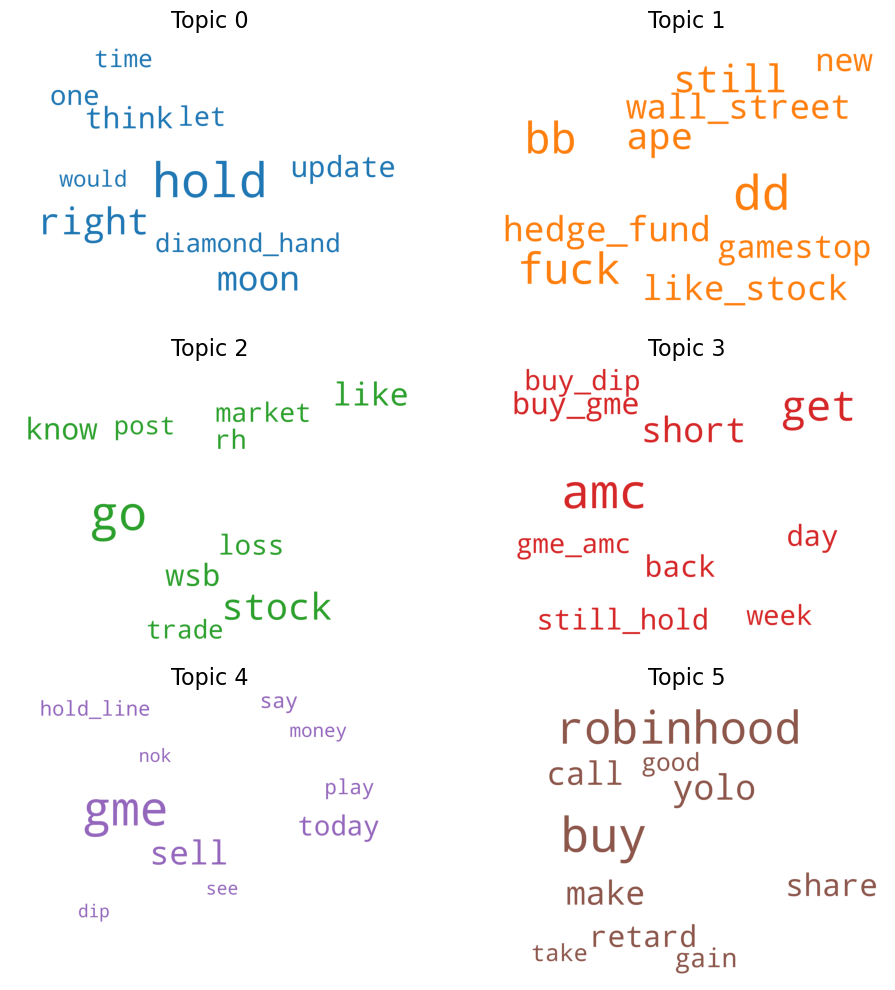

In [14]:
# Extracting a list of colors from the TABLEAU_COLORS dictionary
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# Creating a WordCloud object with specified parameters
cloud = WordCloud(stopwords=stop_words,  # Providing stopwords for the WordCloud
                  background_color='white',  # Setting background color to white
                  width=2500,  # Setting width of the WordCloud
                  height=1800,  # Setting height of the WordCloud
                  max_words=30,  # Limiting maximum number of words in the WordCloud
                  colormap='tab10',  # Setting colormap for colors
                  color_func=lambda *args, **kwargs: cols[i],  # Setting custom color function for the WordCloud
                  prefer_horizontal=1.0)  # Setting horizontal preference for word orientation

# Extracting topics from lda_model and formatting them
topics = lda_model.show_topics(formatted=False)

# Creating a subplot grid for displaying multiple WordClouds
fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

# Iterating over each subplot and displaying WordCloud for each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extracting words for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generating WordCloud from word frequencies
    plt.gca().imshow(cloud)  # Displaying WordCloud on current axis
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))  # Setting title for the WordCloud
    plt.gca().axis('off')  # Turning off axis for cleaner visualization

# Adjusting spacing between subplots and removing unnecessary axis
plt.subplots_adjust(wspace=0, hspace=0)  # Adjusting spacing between subplots
plt.axis('off')  # Turning off axis for the entire figure
plt.margins(x=0, y=0)  # Setting margins to zero for tighter layout
plt.tight_layout()  # Adjusting layout for better visualization
plt.show()  # Displaying the entire plot

## Word Counts of Topic Keywords

c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP\src\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP\src\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP\src\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word

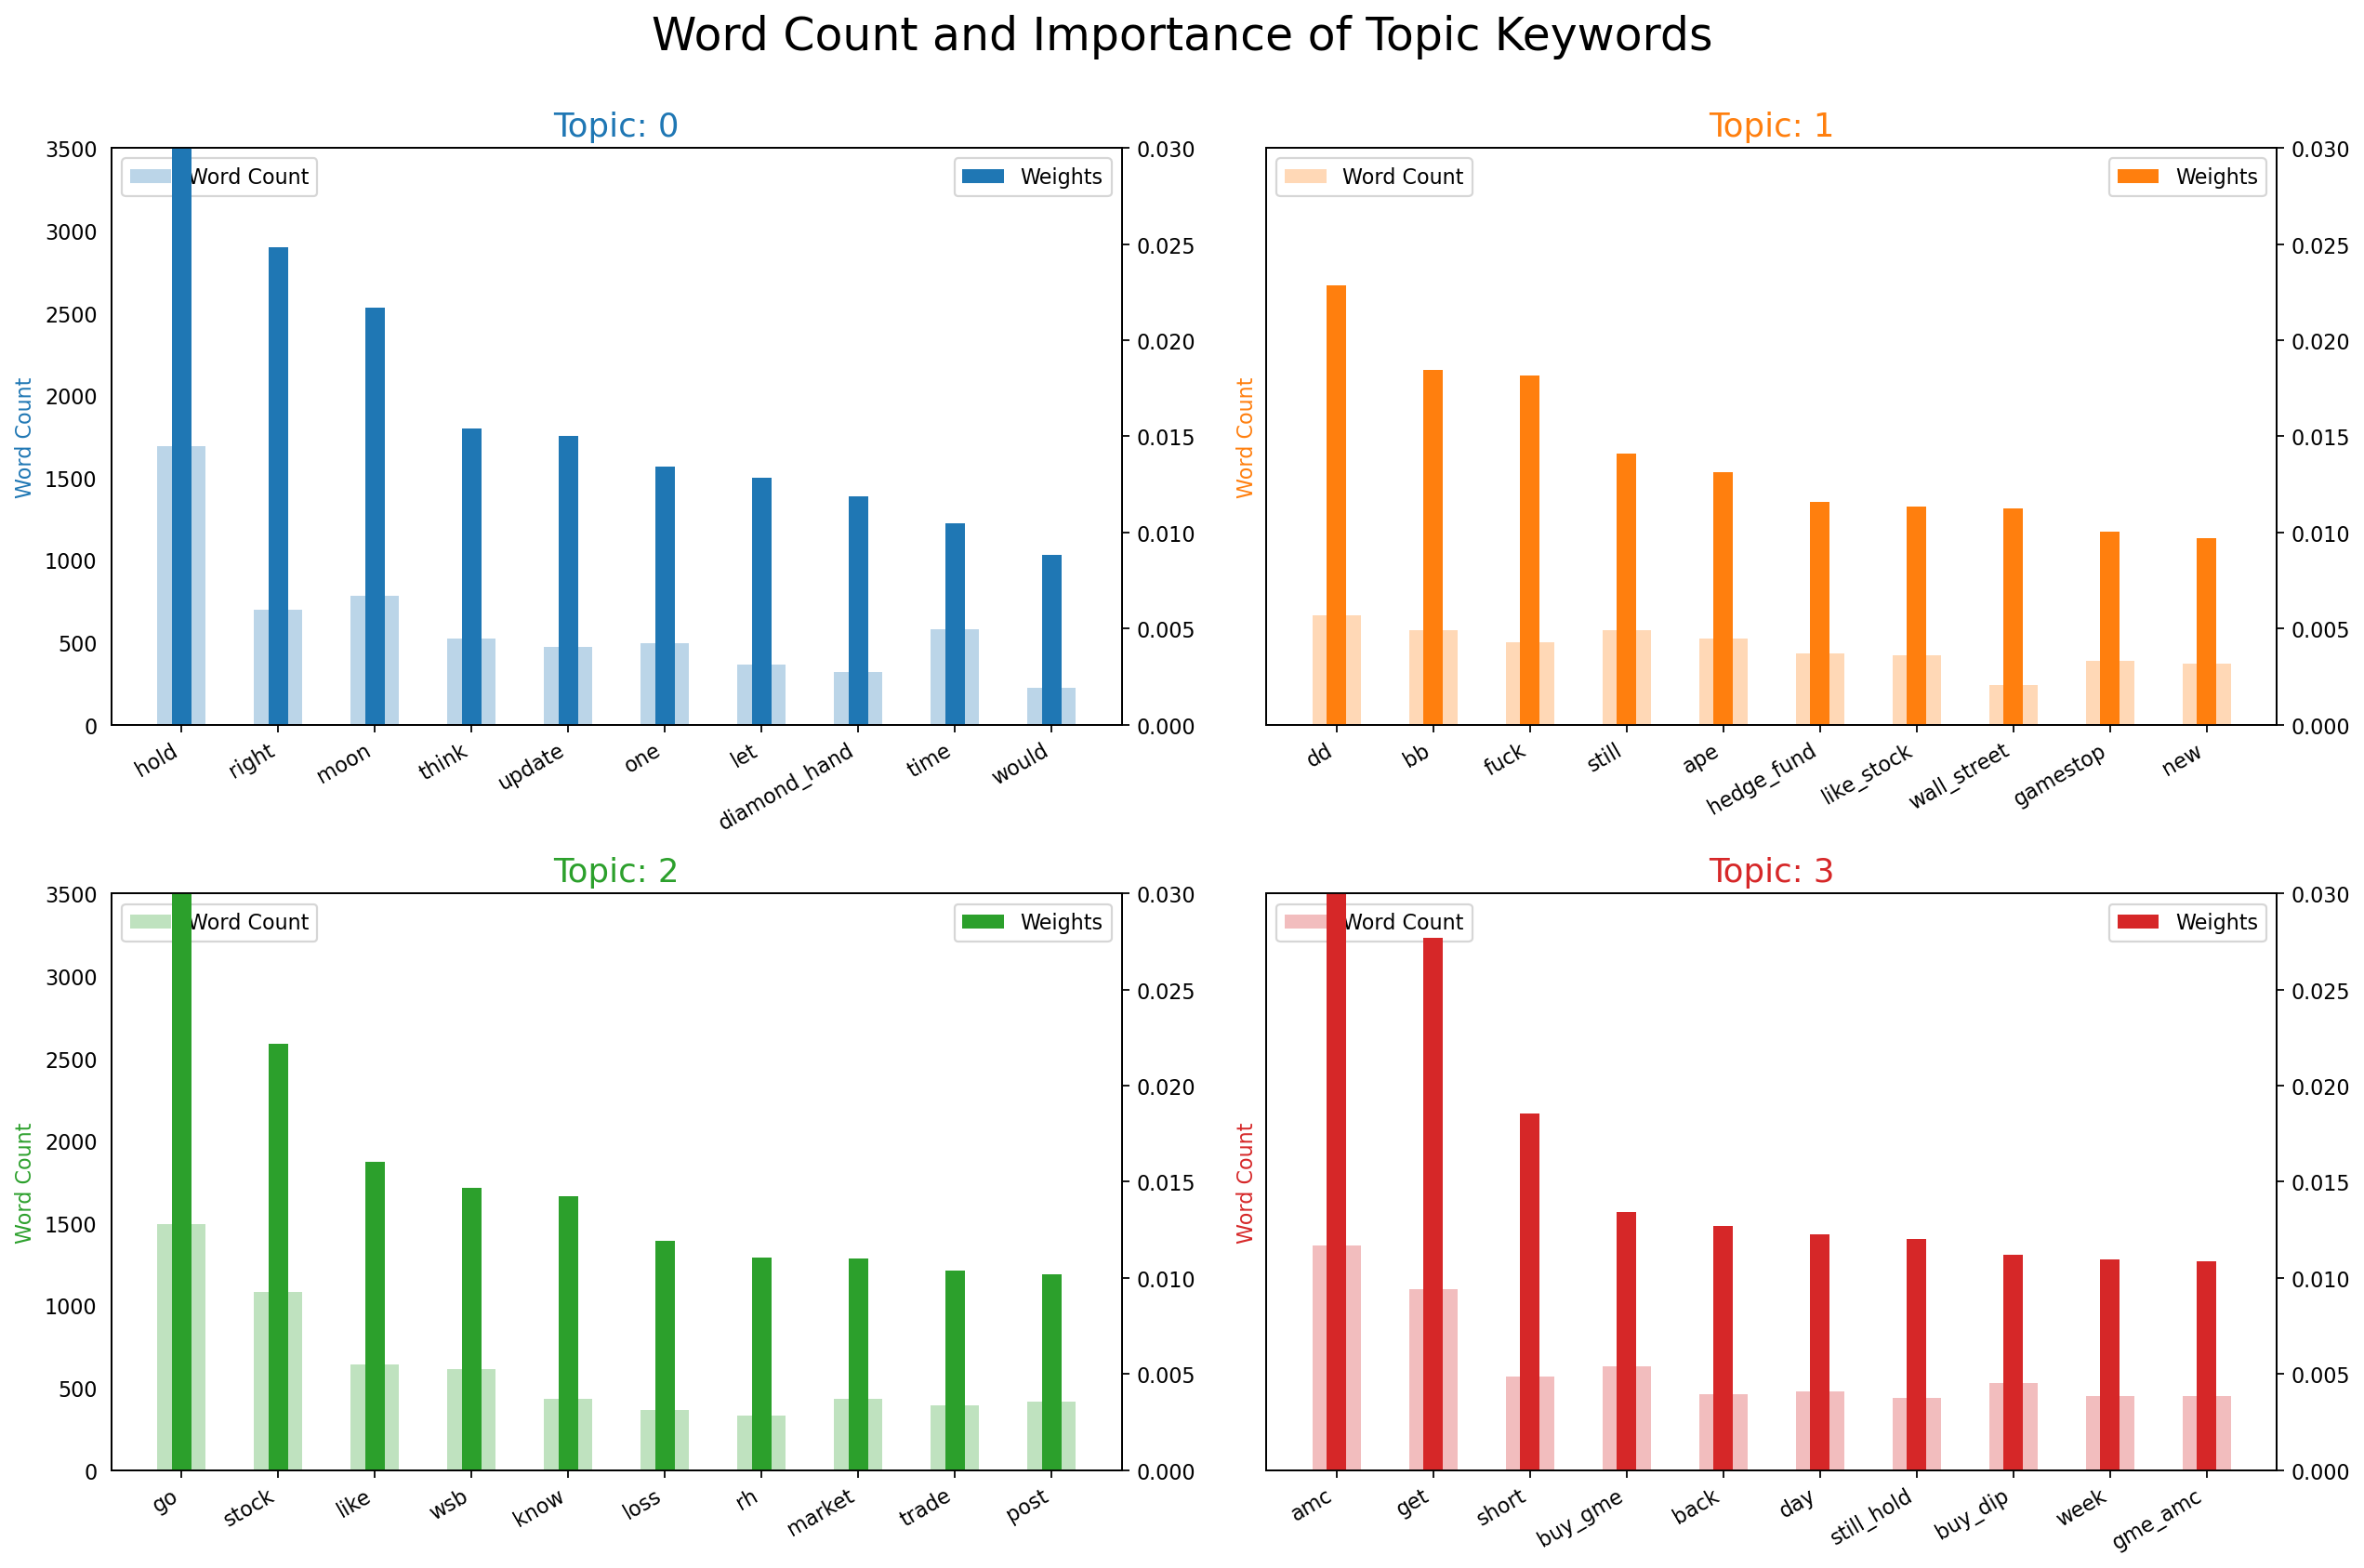

In [15]:
plot_topic_keywords(lda_model, clean_texts)

# PCA Distribution of Topics (PyLDAvis)

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.079449  0.208034       1        1  17.680023
3     -0.270411 -0.203311       2        1  17.242126
4      0.272927 -0.232597       3        1  17.017284
1     -0.001648  0.083526       4        1  16.497029
5     -0.073578  0.103436       5        1  16.470802
0     -0.006739  0.040913       6        1  15.092736, topic_info=           Term         Freq        Total Category  logprob  loglift
32          gme  3739.000000  3739.000000  Default  30.0000  30.0000
116        hold  1631.000000  1631.000000  Default  29.0000  29.0000
22          buy  1690.000000  1690.000000  Default  28.0000  28.0000
146          go  1731.000000  1731.000000  Default  27.0000  27.0000
110   robinhood  1503.000000  1503.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
599    remember   143.892885   144.766185   Topic6  -5.5230   1.8849
1360        sub   143.051449   143.922671   Topic6  -5.5288   1.8849
1042     let_go   140.156258   141.028744   Topic6  -5.5493   1.8848
1183     invest   132.181036   133.055565   Topic6  -5.6079   1.8844
341      advice   130.926716   131.801618   Topic6  -5.6174   1.8843

[210 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2397      3  0.994551  account
341       6  0.993918   advice
189       3  0.998145   almost
400       1  0.997380     also
432       2  0.999660      amc
...     ...       ...      ...
507       6  0.996090    would
404       1  0.998918      wsb
348       4  0.997935     year
216       2  0.997993      yet
204       5  0.998829     yolo

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 2, 6, 1])